In [296]:
from scipy.signal import welch
import fastdyn_fic_dmf as dmf
import numpy as np
import matplotlib.pyplot as plt
# Fetch default parameters
import tracemalloc
from scipy.io import loadmat
from scipy.stats import zscore, pearsonr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mat73
# Helper functions
def compute_fcd(data, wsize, overlap, isubdiag):
    T, N = data.shape
    win_start = np.arange(0, T - wsize - 1, wsize - overlap)
    nwins = len(win_start)
    fcd = np.zeros((len(isubdiag[0]), nwins))
    #print(fcd.shape)
    #print(data.shape)
    #print((data[win_start[2]:win_start[2] + wsize + 1, :]).shape)
    for i in range(nwins):
        tmp = data[win_start[i]:win_start[i] + wsize + 1, :]
        cormat = np.corrcoef(tmp.T)
        fcd[:, i] = cormat[isubdiag[0],isubdiag[1]]
    return fcd


C = loadmat('./data/DTI_fiber_consensus_HCP.mat')['connectivity'][:200, :200]
C = 0.2*C/np.max(C)
N = C.shape[0]



In [297]:

def sim_run(G_VAL, LR, SEED, NB_STEPS=50000):
    """
    INPUTS:
    G_VAL: float, global coupling
    LR: array, learning rate (Homogeneous or heterogenos. Decay will be calcualted for each region with this)
    SEED: int, random seed
    OUTPUTS:
    rates_dyn: np.array, dynamic of rates
    rates_inh_dyn: np.array, dynamic of inhibitory rates
    bold_dyn: np.array, dynamic of BOLD signal
    fic_t_dyn: np.array, dynamic of FIC

    """
    
    params = dmf.default_params(C=C)
    fit_res = np.load("./data/fit_res_3-44.npy")
    b = fit_res[0] # First element is the slope
    a = fit_res[1]
    params['G'] = G_VAL
    params['seed'] = SEED
    params['obj_rate'] = 3.44
    DECAY = np.exp(a+np.log(LR)*b)    
    params['lr_vector'] = LR
    params['taoj_vector'] =  DECAY
    params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
    params["with_decay"] = True
    params["with_plasticity"] = True
    params['return_bold'] = False
    params["return_fic"] = True
    params["return_rate"] = True
    rates_dyn, rates_inh_dyn, _, fic_t_dyn = dmf.run(params, NB_STEPS)
    return rates_dyn, rates_inh_dyn, fic_t_dyn

def sim_run_notplastic(G_VAL, SEED, NB_STEPS=50000):
    """
    INPUTS:
    G_VAL: float, global coupling
    LR: array, learning rate (Homogeneous or heterogenos. Decay will be calcualted for each region with this)
    SEED: int, random seed
    OUTPUTS:
    rates_dyn: np.array, dynamic of rates
    rates_inh_dyn: np.array, dynamic of inhibitory rates
    bold_dyn: np.array, dynamic of BOLD signal
    fic_t_dyn: np.array, dynamic of FIC

    """
    
    params = dmf.default_params(C=C)
    fit_res = np.load("./data/fit_res_3-44.npy")
    b = fit_res[0] # First element is the slope
    a = fit_res[1]
    params['G'] = G_VAL
    params['seed'] = SEED
    params['obj_rate'] = 3.44    
    params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
    params["with_decay"] = False
    params["with_plasticity"] = False
    params['return_bold'] = False
    params["return_fic"] = True
    params["return_rate"] = True
    rates_dyn, rates_inh_dyn, _, fic_t_dyn = dmf.run(params, NB_STEPS)
    return rates_dyn, rates_inh_dyn, fic_t_dyn

import numpy as np

def vectorize_along_axis(axis=0):
    def decorator(func):
        def wrapper(data, *args, **kwargs):
            # if the data is 1D, just call the function directly
            if data.ndim == 1:
                return func(data, *args, **kwargs)
            # otherwise, apply the function along the specified axis
            return np.apply_along_axis(func, axis, data, *args, **kwargs)
        return wrapper
    return decorator

@vectorize_along_axis(axis=0)
def get_autcorr(rates):
    """Get the autocorrelation function from a 1D rates vector."""
    signal = rates - np.mean(rates)
    # Calculate autocorrelation function (full convolution)
    autocorr = np.correlate(signal, signal, mode='full')
    # Normalize: divide by the variance and length of the signal
    autocorr = autocorr / (np.var(signal) * len(signal))
    # Only keep the second half (non-negative lags)
    autocorr = autocorr[len(signal)-1:]
    return autocorr


def get_max_freq_and_power(rates):
    freqs, psd = welch(rates, fs=1000,axis=1,nperseg=4*1000,noverlap=2*1000)
    max_freq_id = np.argmax(psd[:,:100],axis=1)
    max_freqs = freqs[max_freq_id]
    max_power = np.max(psd[:,:100],axis=1)
    return max_freqs, max_power

## Generate control power distribution

In [309]:
import numpy as np
import os
from joblib import Parallel, delayed

LR_HOMO = 100
LR_HOMO_VEC = np.ones(200)*LR_HOMO
SEED = 1
MAX_LAGS = 500
BURNOUT = 5000
AUTOCORR_TMAX = 5000
NB_STEPS = 30000
G_VAL = 3.5
G_VAL_NOTPLASTIC = 2.1
SEED_BASE = 100

def run_simulation(idx, lr):
    SEED = SEED_BASE + idx
    # Create a homogeneous LR vector for all regions
    LR_VEC = np.ones(N) * lr
    # Run simulation (assuming sim_run returns rates, inhibitory rates and fic_t in that order)
    rates, _, _ = sim_run(G_VAL, LR_VEC, SEED, NB_STEPS)
    # Discard burnout period
    return rates[:, BURNOUT:]

def run_simulation_notplastic(idx):
    SEED = SEED_BASE + idx
    # Create a homogeneous LR vector for all regions
    LR_VEC = np.ones(N)
    # Run simulation (assuming sim_run returns rates, inhibitory rates and fic_t in that order)
    rates, _, _ = sim_run_notplastic(G_VAL_NOTPLASTIC, SEED, NB_STEPS)
    # Discard burnout period
    return rates[:, BURNOUT:]
# Execute 100 simulation runs in parallel.
lr = 10000
simulations = Parallel(n_jobs=32)(delayed(run_simulation)(idx, lr) for idx in range(100))
rates_all_high_lr = np.array(simulations)
save_path = f"./Results/homogeneous/g_{G_VAL}_lr_{lr}_100reps_30ksteps.npy"
np.save(save_path, rates_all_high_lr)
lr = 100
simulations = Parallel(n_jobs=32)(delayed(run_simulation)(idx, lr) for idx in range(100))
rates_all_low_lr = np.array(simulations)
save_path = f"./Results/homogeneous/g_{G_VAL}_lr_{lr}_100reps_30ksteps.npy"
np.save(save_path, rates_all_low_lr)
simulations_notplastic = Parallel(n_jobs=32)(delayed(run_simulation_notplastic)(idx) for idx in range(100))
rates_all_notplastic = np.array(simulations_notplastic)
save_path = f"./Results/homogeneous/g_{G_VAL_NOTPLASTIC}_notplastic_100reps_30ksteps.npy"
np.save(save_path, rates_all_notplastic)

# Ensure the output directory exists
#os.makedirs("./Results/homogeneous", exist_ok=True)
#filename = f"./Results/homogeneous/g_{G_VAL}_lr_{lr}.npy"
#np.save(filename, rates_all)
#print(f"Saved homogeneous simulation results for LR = {lr} to {filename}")

In [312]:
NB_STEPS = 15000

In [313]:
r = run_simulation_notplastic(0)
print(r.shape)

(200, 10000)


In [314]:
lr = 10000
simulations = Parallel(n_jobs=32)(delayed(run_simulation)(idx, lr) for idx in range(100))
rates_all_high_lr = np.array(simulations)
save_path = f"./Results/homogeneous/g_{G_VAL}_lr_{lr}_100reps_15ksteps.npy"
np.save(save_path, rates_all_high_lr)
lr = 100
simulations = Parallel(n_jobs=32)(delayed(run_simulation)(idx, lr) for idx in range(100))
rates_all_low_lr = np.array(simulations)
save_path = f"./Results/homogeneous/g_{G_VAL}_lr_{lr}_100reps_15ksteps.npy"
np.save(save_path, rates_all_low_lr)
simulations_notplastic = Parallel(n_jobs=32)(delayed(run_simulation_notplastic)(idx) for idx in range(100))
rates_all_notplastic = np.array(simulations_notplastic)
save_path = f"./Results/homogeneous/g_{G_VAL_NOTPLASTIC}_notplastic_100reps_15ksteps.npy"
np.save(save_path, rates_all_notplastic)

In [315]:

max_freqs_all_high_lr = []
max_powers_all_high_lr = []

for rates in rates_all_high_lr:
    max_freqs, max_powers = get_max_freq_and_power(rates)
    max_freqs_all_high_lr.append(max_freqs)
    max_powers_all_high_lr.append(max_powers)

max_freqs_all_high_lr = np.array(max_freqs_all_high_lr)
max_powers_all_high_lr = np.array(max_powers_all_high_lr)

In [305]:

max_freqs_all_low_lr = []
max_powers_all_low_lr = []

for rates in rates_all_low_lr:
    max_freqs, max_powers = get_max_freq_and_power(rates)
    max_freqs_all_low_lr.append(max_freqs)
    max_powers_all_low_lr.append(max_powers)

max_freqs_all_low_lr = np.array(max_freqs_all_low_lr)
max_powers_all_low_lr = np.array(max_powers_all_low_lr)

In [307]:

max_freqs_all_notplastic = []
max_powers_all_notplastic = []

for rates in rates_all_notplastic:
    max_freqs, max_powers = get_max_freq_and_power(rates)
    max_freqs_all_notplastic.append(max_freqs)
    max_powers_all_notplastic.append(max_powers)

max_freqs_all_notplastic = np.array(max_freqs_all_notplastic)
max_powers_all_notplastic = np.array(max_powers_all_notplastic)

(0.0, 25.0)

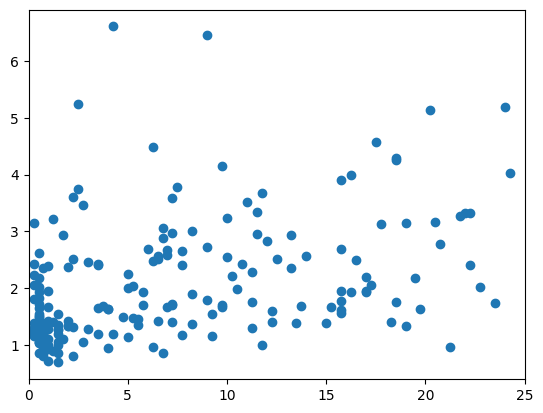

In [356]:
plt.scatter(max_freqs_all_notplastic[1],max_powers_all_notplastic[1])

plt.xlim([0,25])

In [349]:
max_powers_all_notplastic.shape

(100, 200)

In [352]:
np.max(max_powers_all_notplastic,axis=0)[1]

5.178979102040522

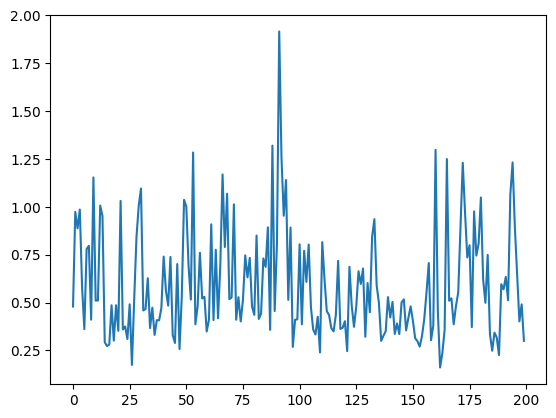

In [341]:
def get_max_freq_and_power(rates):
    freqs, psd = welch(rates, fs=1000,axis=1,nperseg=4*1000,noverlap=2*1000)
    max_freq_id = np.argmax(psd[:,:100],axis=1)
    max_freqs = freqs[max_freq_id]
    max_power = np.max(psd[:,:100],axis=1)
    return max_freqs, max_power

plt.plot(np.max(psd[:,:100],axis=1))

In [343]:
psd[:,:100].T.shape

(100, 200)

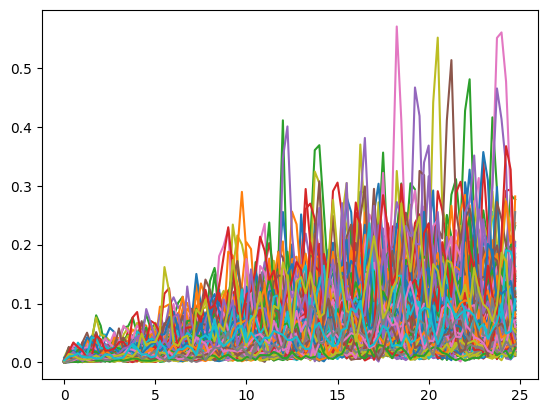

In [355]:
freqs, psd = welch(rates_all_high_lr[1], fs=1000,axis=1,nperseg=4*1000,noverlap=2*1000)
plt.plot(freqs[:100],psd[:,:100].T)
plt.show()

(0.0, 25.0)

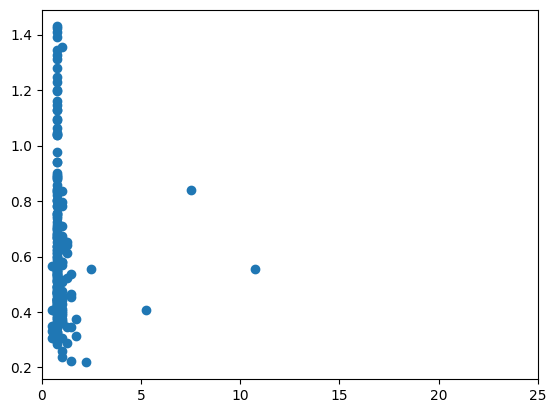

In [306]:
plt.scatter(max_freqs_all_low_lr[1],max_powers_all_low_lr[1])

plt.xlim([0,25])

(0.0, 25.0)

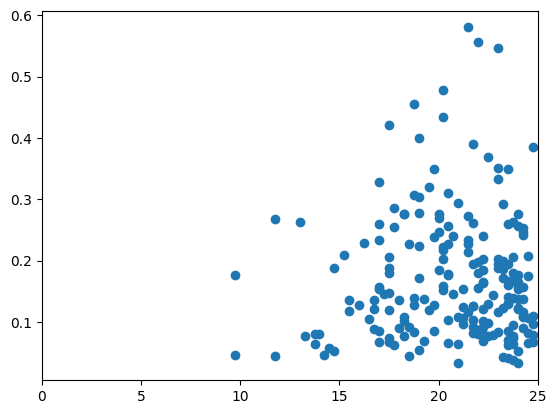

In [325]:
plt.scatter(max_freqs_all_high_lr[10],max_powers_all_high_lr[10])

plt.xlim([0,25])

In [19]:
# Get the mean of means of power accrross all regions
mean_power = max_powers_all.mean(axis=0).mean()
# Get the mean of std of power accrross all regions
std_power = max_powers_all.mean(axis=0).std()
# Get the mean of means of frequency accrross all regions
mean_freq = max_freqs_all.mean(axis=0).mean()
# Get the mean of std of frequency accrross all regions
std_freq = max_freqs_all.mean(axis=0).std()


In [22]:
std_freq

0.39898599912778904

# Heterogeneous with 1 High LR

In [319]:
import density_clustering.dclus as dclust
from matplotlib.pyplot import cm


G_VAL = 3.5
LR_HOMO = 10000
LR_HOMO_VEC = np.ones(200)*LR_HOMO
LR_HET = 100
SELECTED_REGIONS = [10]
LR_HET_VEC = LR_HOMO_VEC.copy()
LR_HET_VEC[SELECTED_REGIONS] = LR_HET
SEED = 1
MAX_LAGS = 500
BURNOUT = 5000
NB_STEPS = 15000

rates, _, _ = sim_run(G_VAL, LR_HOMO_VEC, SEED,NB_STEPS)
# Assert if the power of rates in reg 10 is higher than the ditribution of power
one_reg_het_freq, one_reg_het_power = get_max_freq_and_power(rates)

In [323]:
max_freqs_all_high_lr.shape

(100, 200)

In [ ]:
plt.scatter()

(0.0, 25.0)

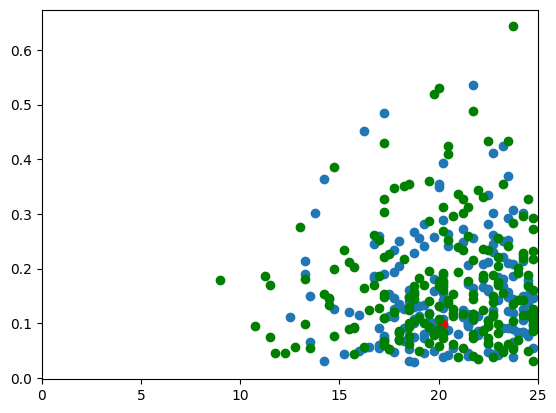

In [324]:
plt.scatter(one_reg_het_freq,one_reg_het_power)
plt.scatter(one_reg_het_freq[10],one_reg_het_power[10], color='red')
plt.scatter(max_freqs_all_high_lr[0],max_powers_all_high_lr[0],color='green')
plt.xlim([0,25])

In [ ]:
freqs, psd = welch(rates, fs=1000,axis=1,nperseg=4*1000,noverlap=2*1000)
max_freq_id = np.argmax(psd[:,:100],axis=1)
max_freqs = freqs[max_freq_id]
max_power = np.max(psd[:,:100],axis=1)
plt.scatter(max_freqs,max_power)
plt.xlim([0, 25])
plt.show()

In [238]:
psd.shape

(200, 4001)

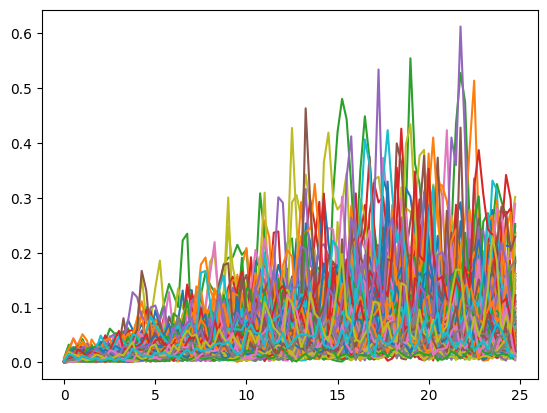

In [244]:
plt.plot(freqs[:100],psd[:,:100].T)
plt.show()

# Groups of heterogeneity

In [119]:
from bct import score_wu, rich_club_wu
# Select the nodes with the hihgest node strength from SC matrix C
node_strength = np.mean(C,axis=0)
# Get the 10 lowest regions
most_connected = np.argsort(node_strength)[::-1]

score_levels = np.arange(0.02,1.6,0.01)
score_idxs = []
for level in score_levels:
    score, sn = score_wu(C,level)
    # Get the indices from score that have > 0 values
    if sn>0:
        score_idxs.append(np.where(np.sum(score,axis=0) > 0)[0]) 


# Most connected regions

NCLUS=1


Text(0.5, 0.92, 'LR_HOMO = 10000 - LR_HET = 100 - dc = 0.08 - ci_alpha = 0.2')

) missing from font(s) DejaVu Sans.fic_h/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 13 (
  func(*args, **kwargs)
) missing from font(s) DejaVu Sans.fic_h/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


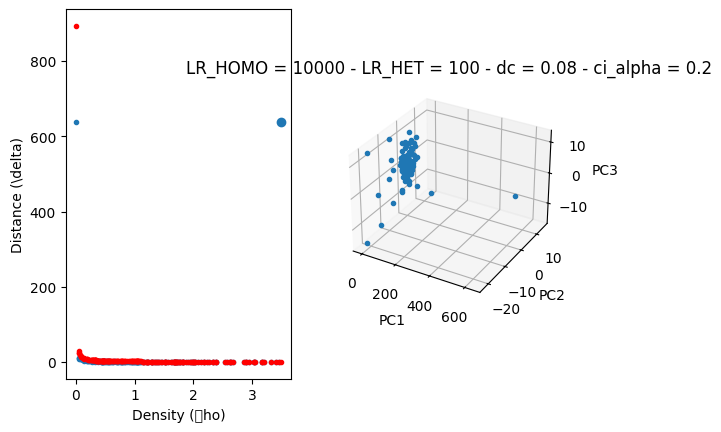

In [292]:
from tkinter.tix import AUTO
from scipy.spatial import distance
from scipy.stats import zscore
import density_clustering.dclus as dclust
from matplotlib.pyplot import cm


G_VAL = 3.5
LR_HOMO = 10000
LR_HOMO_VEC = np.ones(200)*LR_HOMO
LR_HET = 100
SELECTED_REGIONS = most_connected[:10]
LR_HET_VEC = LR_HOMO_VEC.copy()
LR_HET_VEC[SELECTED_REGIONS] = LR_HET
SEED = 1
MAX_LAGS = 500
BURNOUT = 5000
AUTOCORR_TMAX = 3000
NB_STEPS = 15000

rates, _, _ = sim_run(G_VAL, LR_HET_VEC, SEED,NB_STEPS)
rates = rates[:,BURNOUT:]
autocorr_all = get_autcorr(rates[:,:AUTOCORR_TMAX])

numpcs = 3
ishalo = 0
dc = 0.08 # neighborhood parameter. EXPLORE WITH THIS. fOR VALUES <.04 will generate an error for this data
ci_alpha = 0.2 # threshold for centroids detection. EXPLORE THIS AS WELL
# PCA
distmat,proj_data = dclust.pca_and_distance(autocorr_all.T,numpcs)

rho,delta,centid,cluslabels,halolabels,threshold = dclust.clustering_by_density(distmat,dc,ci_alpha,ishalo)
nclus = int(np.max(cluslabels))
print(f"NCLUS={nclus}")
color = cm.tab20(np.linspace(0, 1, nclus))
dclust.plot_clustering_summary(delta,rho,centid,cluslabels,threshold,proj_data,color)
plt.title(f"LR_HOMO = {LR_HOMO} - LR_HET = {LR_HET} - dc = {dc} - ci_alpha = {ci_alpha}")

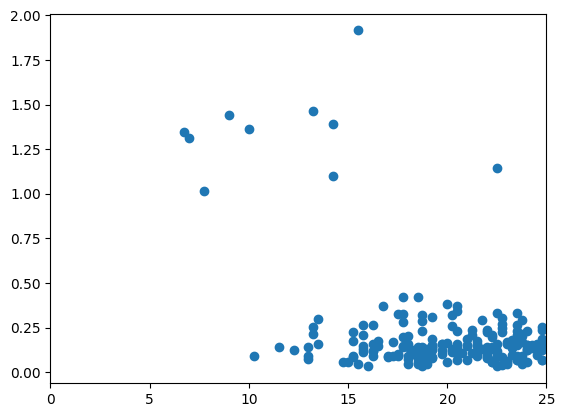

In [293]:
freqs, psd = welch(rates, fs=1000,axis=1,nperseg=4*1000,noverlap=2*1000)
max_freq_id = np.argmax(psd[:,:100],axis=1)
max_freqs = freqs[max_freq_id]
max_power = np.max(psd[:,:100],axis=1)
plt.scatter(max_freqs,max_power)
plt.xlim([0, 25])
plt.show()

# S-core regions

NCLUS=2


) missing from font(s) DejaVu Sans.fic_h/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 13 (
  func(*args, **kwargs)
) missing from font(s) DejaVu Sans.fic_h/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


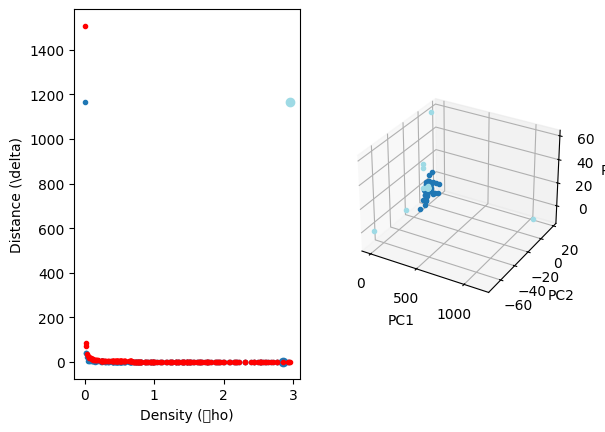

In [294]:
from scipy.spatial import distance
from scipy.stats import zscore
import density_clustering.dclus as dclust
from matplotlib.pyplot import cm


G_VAL = 3.5
LR_HOMO = 10000
LR_HOMO_VEC = np.ones(200)*LR_HOMO
LR_HET = 100
highest_score = score_idxs[-1]
SELECTED_REGIONS = highest_score
LR_HET_VEC = LR_HOMO_VEC.copy()
LR_HET_VEC[SELECTED_REGIONS] = LR_HET
SEED = 1
MAX_LAGS = 500
BURNOUT = 5000
NB_STEPS = 15000

rates, _, _ = sim_run(G_VAL, LR_HET_VEC, SEED,NB_STEPS)
rates = rates[:,BURNOUT:]
AUTOCORR_TMAX = 5000
autocorr_all = get_autcorr(rates)

numpcs = 3
ishalo = 0
dc = 0.08 # neighborhood parameter. EXPLORE WITH THIS. fOR VALUES <.04 will generate an error for this data
ci_alpha = 0.2 # threshold for centroids detection. EXPLORE THIS AS WELL
# PCA
distmat,proj_data = dclust.pca_and_distance(autocorr_all.T,numpcs)

rho,delta,centid,cluslabels,halolabels,threshold = dclust.clustering_by_density(distmat,dc,ci_alpha,ishalo)
nclus = int(np.max(cluslabels))
print(f"NCLUS={nclus}")
color = cm.tab20(np.linspace(0, 1, nclus))
dclust.plot_clustering_summary(delta,rho,centid,cluslabels,threshold,proj_data,color)

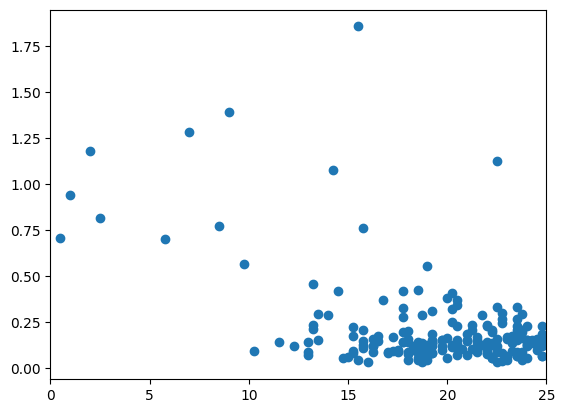

In [295]:
freqs, psd = welch(rates, fs=1000,axis=1,nperseg=4*1000,noverlap=2*1000)
max_freq_id = np.argmax(psd[:,:100],axis=1)
max_freqs = freqs[max_freq_id]
max_power = np.max(psd[:,:100],axis=1)
plt.scatter(max_freqs,max_power)
plt.xlim([0, 25])
plt.show()

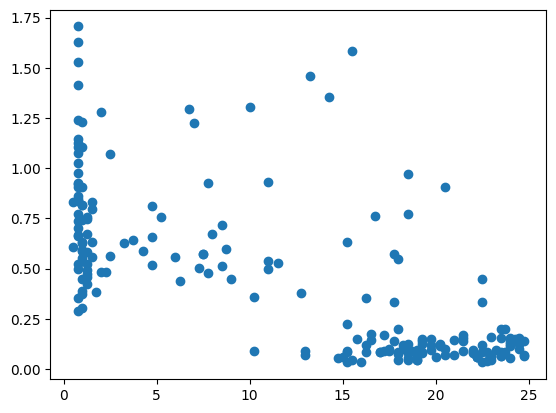

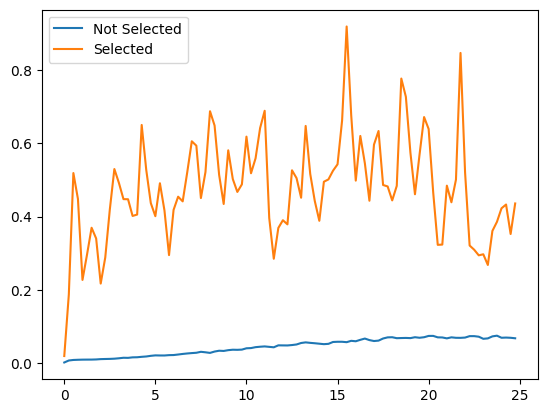

In [269]:
NOT_SELECTED = np.setdiff1d(np.arange(200),SELECTED_REGIONS)
plt.plot(freqs[:100],np.mean(psd[NOT_SELECTED,:100],axis=0),label="Not Selected")
plt.plot(freqs[:100],np.mean(psd[SELECTED_REGIONS,:100],axis=0),label="Selected")
plt.legend()
plt.show()
